# **Adaptive Gradient algorithm**

In [1]:
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
#we define a vector space of R^3 and a convex set 

In [2]:
def generate_random_convex_set(dim=2, num_points=10, bounds=(0, 10)):
    """
    Generate a random convex set in the form of a convex hull.
    
    Args:
        dim (int): Dimension of the vector space.
        num_points (int): Number of random points to generate.
        bounds (tuple): The range (min, max) for generating points.
        
    Returns:
        points (np.ndarray): Array of points in the convex hull.
        hull (ConvexHull): The ConvexHull object defining the convex set.
    """
    # Generate random points within the given bounds
    points = np.random.uniform(bounds[0], bounds[1], size=(num_points, dim))
    
    # Compute the convex hull of the points
    hull = ConvexHull(points)
    
    return points, hull

In [3]:
def plot_convex_set(points, hull):
    """
    Plot the convex set in 2D.
    
    Args:
        points (np.ndarray): Points in the space.
        hull (ConvexHull): The ConvexHull object defining the convex set.
    """
    plt.plot(points[:, 0], points[:, 1], 'o')  # Plot points
    
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'k-')  # Plot edges of the convex hull
    
    plt.title("Random Convex Set (Convex Hull)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

In [4]:
def plot_convex_set_3d(points, hull, azim=45, elev=30):
    """
    Plot the convex set in 3D with adjustable viewing angles.
    
    Args:
        points (np.ndarray): Points in the space.
        hull (ConvexHull): The ConvexHull object defining the convex set.
        azim (float): Azimuthal angle for viewing the 3D plot.
        elev (float): Elevation angle for viewing the 3D plot.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the points
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='r', marker='o')
    
    # Plot the convex hull faces
    for simplex in hull.simplices:
        vertices = points[simplex]
        tri = Poly3DCollection([vertices], alpha=0.5, edgecolor='k')
        ax.add_collection3d(tri)
    
    # Set viewing angles
    ax.view_init(elev=elev, azim=azim)
    
    ax.set_title("Random Convex Set (3D Convex Hull)")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

In [5]:
def define_function_over_convex_set(points, hull):
    """
    Define a function over a convex set.
    
    Args:
        points (np.ndarray): Points defining the convex set.
        hull (ConvexHull): The ConvexHull object defining the convex set.
        
    Returns:
        func (callable): A function defined over the convex set.
    """
    def func(x, y, z):
        """
        Example quadratic function over the convex set.
        
        Args:
            x (float): X-coordinate.
            y (float): Y-coordinate.
            z (float): Z-coordinate.
        
        Returns:
            float: Value of the function at (x, y, z).
        """
        # Example function: quadratic form
        return x**2 + y**2 + z**2
    
    def is_inside_convex_set(x, y, z):
        """
        Check if a point is inside the convex set.
        
        Args:
            x (float): X-coordinate.
            y (float): Y-coordinate.
            z (float): Z-coordinate.
        
        Returns:
            bool: True if the point is inside the convex hull.
        """
        # Create the point as a 1x3 array
        point = np.array([x, y, z])
        
        # Check if the point is inside the convex hull using half-space inequalities
        return np.all(np.dot(hull.equations[:, :-1], point) + hull.equations[:, -1] <= 1e-8)
    
    def wrapped_func(x, y, z):
        """
        Wrapper to ensure the function is only evaluated inside the convex set.
        
        Args:
            x (float): X-coordinate.
            y (float): Y-coordinate.
            z (float): Z-coordinate.
        
        Returns:
            float: Value of the function if inside the convex set, NaN otherwise.
        """
        if is_inside_convex_set(x, y, z):
            return func(x, y, z)
        else:
            return np.nan  # Return NaN for points outside the convex set
    
    return wrapped_func

In [1]:
def plot_function_over_convex_set(points, hull, func, resolution=50):
    """
    Plot a function over a convex set in 3D.
    
    Args:
        points (np.ndarray): Points defining the convex set.
        hull (ConvexHull): The ConvexHull object defining the convex set.
        func (callable): Function defined over the convex set.
        resolution (int): Number of points per axis for sampling the function.
    """
    # Get the bounds of the convex set
    min_bounds = np.min(points, axis=0)
    max_bounds = np.max(points, axis=0)
    
    # Generate a grid of points within the bounding box
    x = np.linspace(min_bounds[0], max_bounds[0], resolution)
    y = np.linspace(min_bounds[1], max_bounds[1], resolution)
    z = np.linspace(min_bounds[2], max_bounds[2], resolution)
    X, Y, Z = np.meshgrid(x, y, z)
    
    # Flatten the grid to evaluate the function
    grid_points = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T
    
    # Evaluate the function only at points inside the convex set
    values = []
    for point in grid_points:
        if np.all(np.dot(hull.equations[:, :-1], point) + hull.equations[:, -1] <= 1e-8):
            values.append(func(*point))
        else:
            values.append(np.nan)
    
    values = np.array(values).reshape(X.shape)
    
    # Plot the function as a 3D scatter plot with color indicating function value
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot only non-NaN values
    valid_mask = ~np.isnan(values)
    ax.scatter(X[valid_mask], Y[valid_mask], Z[valid_mask], c=values[valid_mask], cmap='Paired', marker='o')
    
    ax.set_title("Function Over Convex Set")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show() 

In [7]:
def compute_gradient(func, x, y, z, h=1e-5):
    """
    Compute the numerical gradient of a function at a given point using central differences.
    
    Args:
        func (callable): Function to compute the gradient for.
        x, y, z (float): Coordinates of the point.
        h (float): Step size for finite differences.
    
    Returns:
        np.ndarray: Gradient vector [df/dx, df/dy, df/dz].
    """
    df_dx = (func(x + h, y, z) - func(x - h, y, z)) / (2 * h)
    df_dy = (func(x, y + h, z) - func(x, y - h, z)) / (2 * h)
    df_dz = (func(x, y, z + h) - func(x, y, z - h)) / (2 * h)
    return np.array([df_dx, df_dy, df_dz])

In [8]:
def plot_function_gradients(points, hull, func, resolution=10, scale=0.5):
    """
    Plot the gradients of a function over a convex set in 3D.
    
    Args:
        points (np.ndarray): Points defining the convex set.
        hull (ConvexHull): The ConvexHull object defining the convex set.
        func (callable): Function defined over the convex set.
        resolution (int): Number of points per axis for sampling the function.
        scale (float): Scaling factor for gradient vectors.
    """
    # Get the bounds of the convex set
    min_bounds = np.min(points, axis=0)
    max_bounds = np.max(points, axis=0)
    
    # Generate a grid of points within the bounding box
    x = np.linspace(min_bounds[0], max_bounds[0], resolution)
    y = np.linspace(min_bounds[1], max_bounds[1], resolution)
    z = np.linspace(min_bounds[2], max_bounds[2], resolution)
    X, Y, Z = np.meshgrid(x, y, z)
    
    # Flatten the grid for computation
    grid_points = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T
    
    # Compute gradients only for points inside the convex set
    gradients = []
    valid_points = []
    for point in grid_points:
        if np.all(np.dot(hull.equations[:, :-1], point) + hull.equations[:, -1] <= 1e-8):
            grad = compute_gradient(func, *point)
            gradients.append(grad)
            valid_points.append(point)
    
    gradients = np.array(gradients)
    valid_points = np.array(valid_points)
    
    # Plot the gradients as quiver plot in 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Extract valid points and gradient components
    x, y, z = valid_points[:, 0], valid_points[:, 1], valid_points[:, 2]
    u, v, w = gradients[:, 0], gradients[:, 1], gradients[:, 2]
    
    # Plot the gradient vectors
    ax.quiver(x, y, z, u, v, w, length=scale, normalize=True, color='blue')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='r', marker='o', alpha=0.3)  # Convex set points
    
    ax.set_title("Gradients of the Function Over Convex Set")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

In [9]:
points, hull = generate_random_convex_set(dim=3, num_points=20, bounds=(-10, 10, 10))

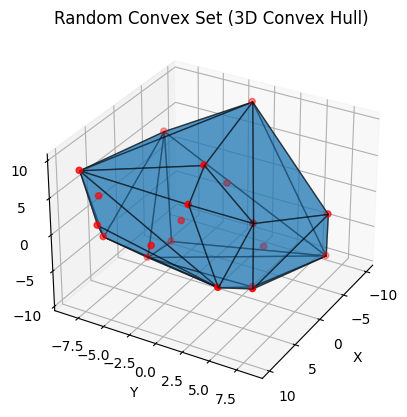

In [10]:
plot_convex_set_3d(points, hull, azim=30, elev=30)

In [11]:
function_over_set = define_function_over_convex_set(points, hull)

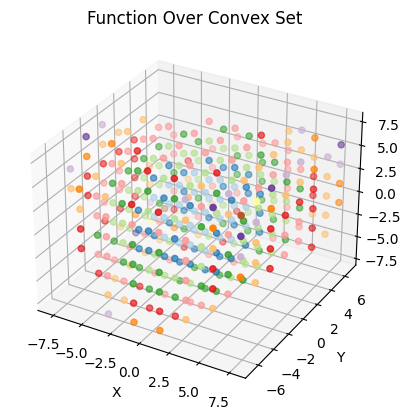

In [12]:
plot_function_over_convex_set(points, hull, function_over_set, resolution=10)

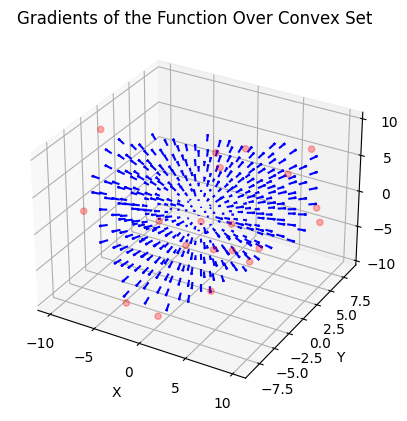

In [13]:
plot_function_gradients(points, hull, function_over_set, resolution=10, scale=0.8)

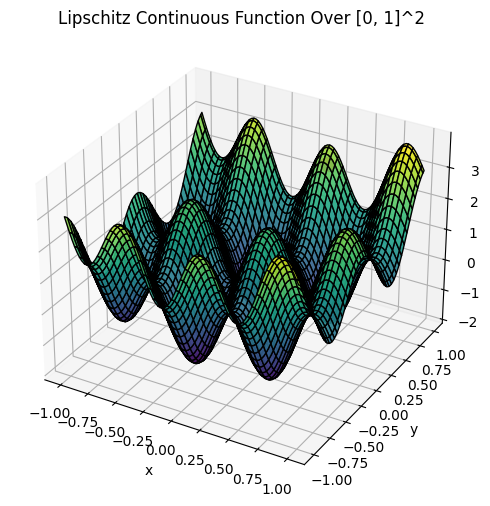

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# Define the Lipschitz function for a grid
def f(x, y, L=1.0):
    """
    Compute the Lipschitz function over a grid.
    
    Parameters:
        X1, X2 (numpy.ndarray): Grid values for two dimensions, must be the same shape.
        L (float): The Lipschitz constant.
        
    Returns:
        numpy.ndarray: Computed function values at each grid point.
    """
    # return (x**2 + y**2)
    return L * (x**2 + y**2 + np.sin(3 * np.pi * x) + np.cos(2 * np.pi * y))

def fp(f, x, y, var='x', h=1e-5):
    """
    Compute the numerical derivative of f with respect to x or y.

    :param f: Function of two variables (x, y)
    :param x: The x-coordinate for derivative calculation
    :param y: The y-coordinate for derivative calculation
    :param var: The variable to differentiate with respect to ('x' or 'y')
    :param h: Step size for finite differences
    :return: The derivative of f with respect to the specified variable
    """
    if var == 'x':
        return (f(x + h, y) - f(x - h, y)) / (2 * h)
    elif var == 'y':
        return (f(x, y + h) - f(x, y - h)) / (2 * h)
    else:
        raise ValueError("Variable must be 'x' or 'y'")

# Create a grid of points for [0, 1]^2
n_points = 100
x = np.linspace(-1, 1, n_points)
y = np.linspace(-1, 1, n_points)
X, Y = np.meshgrid(x, y)

# Compute Z values using the Lipschitz function
L = 1 # Lipschitz constant
Z = f(X, Y, L)

# Plot the Lipschitz continuous function
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k', alpha=0.9)
highlight_x = 0.2
highlight_y = 0.9
highlight_z = f(np.array([[highlight_x]]), np.array([[highlight_y]]), L)[0, 0]
ax.scatter(highlight_x, highlight_y, highlight_z, color='red', s=100, label='Highlighted Point')
ax.set_title("Lipschitz Continuous Function Over [0, 1]^2")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x, y)")
plt.show()

In [48]:
# Uniform Gradient Method to minimize a Lipschitz function
def uniform_gradient_method(L=1.0, p=10):
    x1 = np.linspace(0, 1, p + 1)
    x2 = np.linspace(0, 1, p + 1)
    minval = 1.0
    a = 0
    b = 0
    for i in range(p):
        for j in range(p):
            if (minval < f(x1[i], x2[j], L)):
                a = x1[i]
                b = x2[j]
                minval = f(x1[i], x2[j], L)
    return minval, a, b

# Run the uniform gradient method
L = 1.0  # Lipschitz constant
p = 7    # Discretization parameter
learning_rate = 0.05

min_value, a, b = uniform_gradient_method(L, p)
print(a, b)
print(f"Function value at minimum point: {min_value}")

0.8571428571428571 0.8571428571428571
Function value at minimum point: 3.0678054691425976


1.1403038618956711 0.4583067949172748
Function value at minimum point: -0.42483603416418314


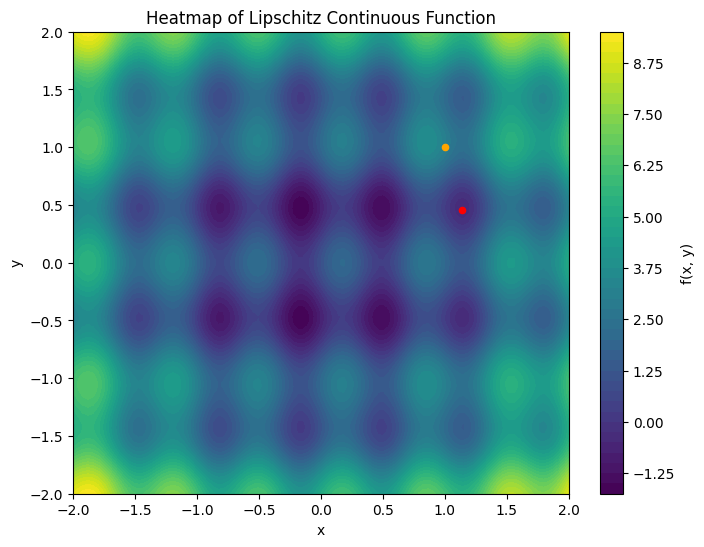

In [50]:
import numpy as np
#pg 25 1.2.9

def gradient_method(n, L, h, method = 1):
    """
    method 1 = simple method (advanced in the textbook)
    method 2 = full relaxation (theoritically sound but practically its 
        impossible to calculate all possible values so i just calculated from -1 to 1)
    method 3 = goldstein-armijo rule
    """

    def f(x,y,L=1.0): 
        # return L * (x**2 + y**2)
        return L * (x**2 + y**2 + np.sin(3 * np.pi * x) + np.cos(2 * np.pi * y))

    def fp(f, x, y, var='x'): 
        h = 1e-6
        if var == 'x':
            return (f(x + h, y) - f(x - h, y)) / (2 * h)
        elif var == 'y':
            return (f(x, y + h) - f(x, y - h)) / (2 * h)
        else:
            raise ValueError("Variable must be 'x' or 'y'")
    
    x = initx
    y = inity
    for k in range(n):
        gx = fp(f, x, y, var='x')
        gy = fp(f, x, y, var='y')
        x = x - (h*gx)
        y = y - (h*gy)
        if method == 1: #advanced
            h = h/((k+1)**0.5)
        elif method == 2: # full relaxation
            poss_val = np.linspace(0, 1, 100)
            best_h = h
            best_value = f(x - h * gx, y - h * gy)
            for all_h in poss_val:
                test_value = f(x - all_h * gx, y - all_h * gy)
                if test_value < best_value:
                    best_h = all_h
                    best_value = test_value
            h = best_h
        else: #goldstein-armijo rule
            alpha = 0.6
            beta = 0.7
            while True:
                newx = x - (h * fp(f, x, y, var='x'))
                newy = y - (h * fp(f, x, y, var='y'))
                subXnew = f(x, y) - f(newx, newy)
                grad = np.array([gx, gy])
                deltaX = np.array([x-newx, y-newy])
                alphaCond = subXnew >= alpha * np.dot(grad, deltaX)
                betaaCond = subXnew <= beta * np.dot(grad, deltaX)
                if alphaCond and betaaCond:
                    break
                h *=0.8 #change step size
            
    return f(x,y), x, y
L = 1.0  # Lipschitz constant
initx = 1
inity = 1
min_value, a, b = gradient_method(10000, L, h=0.1, method=1) #optimal value for h = 1/L but trying other values for experimentation
#method 1 at h=0.2 behaves weird. it doesnt stop at any local minimum or maximum. however small perturbations (>0.075) work fine
#I cannot seem to find the relationship between the h value and the local minimum that is being chosen by the method=1
print(a, b)
print(f"Function value at minimum point: {min_value}")

n_points = 100
x = np.linspace(-2, 2, n_points)
y = np.linspace(-2, 2, n_points)
X, Y = np.meshgrid(x, y)
Z = f(X, Y, L)
z = f(a, b, L)
plt.figure(figsize=(8, 6))
heatmap = plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(heatmap, label='f(x, y)')
plt.scatter(a, b, color='red', s=20)
plt.scatter(initx, inity, color='orange', s=20)
plt.title("Heatmap of Lipschitz Continuous Function")
plt.xlabel("x")
plt.ylabel("y")
plt.show()